Tamaño del dataset: (100, 31), Balance de clases:
0    80
1    20
Name: count, dtype: int64


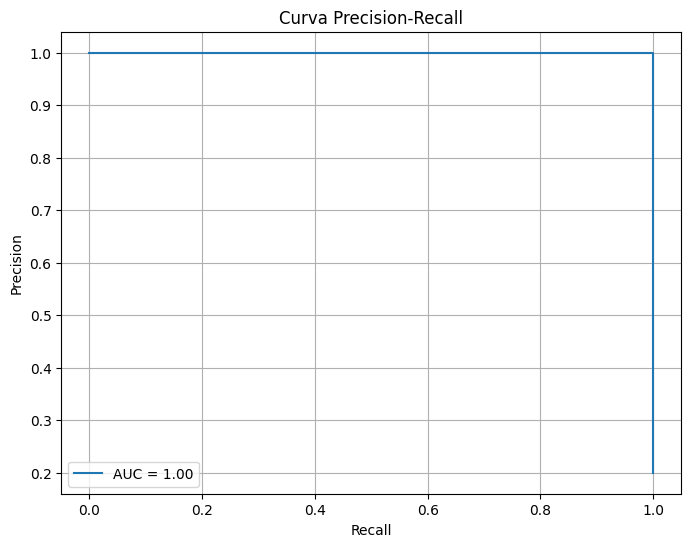

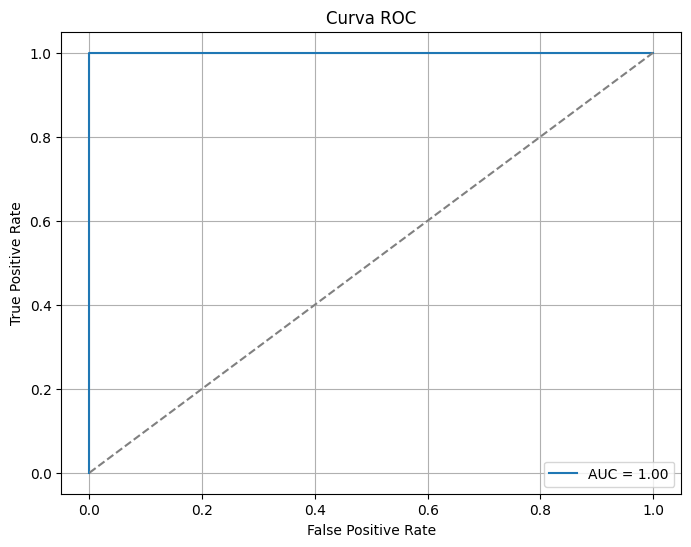


🔍 Mejor threshold por F1: 0.32
✅ F1 en ese threshold: 1.000

📊 Matriz de Confusión (test):
[[24  0]
 [ 0  6]]

📋 Reporte de Clasificación (test):
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        24
           1      1.000     1.000     1.000         6

    accuracy                          1.000        30
   macro avg      1.000     1.000     1.000        30
weighted avg      1.000     1.000     1.000        30


🔁 Evaluación con validación cruzada (5-fold)...

📊 Matriz de Confusión (CV):
[[79  1]
 [ 8 12]]

📋 Reporte de Clasificación (CV):
              precision    recall  f1-score   support

           0      0.908     0.988     0.946        80
           1      0.923     0.600     0.727        20

    accuracy                          0.910       100
   macro avg      0.916     0.794     0.837       100
weighted avg      0.911     0.910     0.902       100


✅ Modelo guardado en '../models/xgb_model.pkl'
✅ Threshold guardado

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import (
    precision_recall_curve, roc_curve, auc, f1_score,
    confusion_matrix, classification_report
)

# ---------- Función para cargar y limpiar ----------
def cargar_y_filtrar_csv(filepath, columnas_eliminar=None):
    df = pd.read_csv(filepath)
    if columnas_eliminar:
        df = df.drop(columns=columnas_eliminar, errors='ignore')
    return df

# ---------- Columnas a eliminar ----------
columnas_a_quitar = ['fecha_segundo_producto_ts', 'combinacion_productos']

# ---------- Cargar datos ----------
X = cargar_y_filtrar_csv("../data/processed/X_xgb_reduced.csv", columnas_a_quitar)
y = pd.read_csv("../data/processed/y_xgb_reduced.csv").values.ravel()

print(f"Tamaño del dataset: {X.shape}, Balance de clases:\n{pd.Series(y).value_counts()}")

# ---------- Separar datos (70% train, 30% test) ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ---------- Modelo XGBoost optimizado ----------
tuned_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.2,
    subsample=1.0,
    colsample_bytree=0.7,
    eval_metric='logloss'
)
tuned_xgb.fit(X_train, y_train)

# ---------- Evaluación en Test ----------
y_scores = tuned_xgb.predict_proba(X_test)[:, 1]

# --- Curva PR ---
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"AUC = {pr_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.grid(True)
plt.legend()
plt.show()

# --- Curva ROC ---
fpr, tpr, thresholds_roc = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.grid(True)
plt.legend()
plt.show()

# --- Mejor threshold por F1 ---
f1_scores = [f1_score(y_test, y_scores >= t) for t in thresholds_pr]
best_threshold = thresholds_pr[np.argmax(f1_scores)]
print(f"\n🔍 Mejor threshold por F1: {best_threshold:.2f}")
print(f"✅ F1 en ese threshold: {max(f1_scores):.3f}")

# --- Predicción final con threshold ---
y_pred_thresh = (y_scores >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_thresh)
print("\n📊 Matriz de Confusión (test):")
print(cm)

print("\n📋 Reporte de Clasificación (test):")
print(classification_report(y_test, y_pred_thresh, digits=3))

# ---------- Validación cruzada ----------
print("\n🔁 Evaluación con validación cruzada (5-fold)...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(tuned_xgb, X, y, cv=skf)

print("\n📊 Matriz de Confusión (CV):")
print(confusion_matrix(y, y_pred_cv))

print("\n📋 Reporte de Clasificación (CV):")
print(classification_report(y, y_pred_cv, digits=3))

# ---------- Guardar modelo y threshold ----------
joblib.dump(tuned_xgb, "../models/xgb_model.pkl")
with open("../models/xgb_threshold.txt", "w") as f:
    f.write(str(best_threshold))

print("\n✅ Modelo guardado en '../models/xgb_model.pkl'")
print("✅ Threshold guardado en '../models/xgb_threshold.txt'")

In [4]:
print(X.shape, pd.Series(y).value_counts())


(100, 31) 0    80
1    20
Name: count, dtype: int64


Tamaño del dataset: (100, 31), Balance de clases:
0    80
1    20
Name: count, dtype: int64


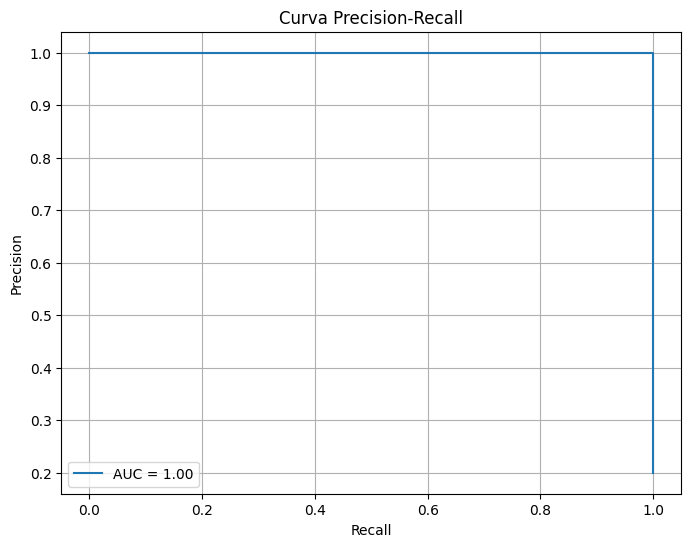

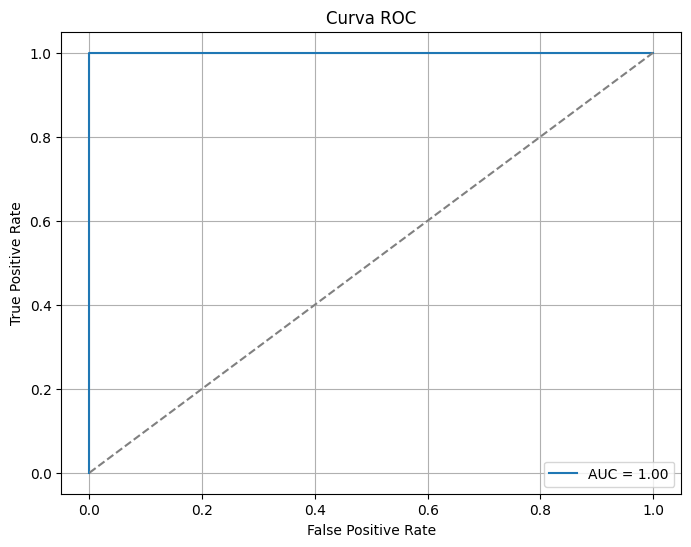


🔍 Mejor threshold por F1: 0.32
✅ F1 en ese threshold: 1.000

📊 Matriz de Confusión (Test):
[[24  0]
 [ 0  6]]

📋 Reporte de Clasificación (Test):
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        24
           1      1.000     1.000     1.000         6

    accuracy                          1.000        30
   macro avg      1.000     1.000     1.000        30
weighted avg      1.000     1.000     1.000        30


🔁 Evaluación con validación cruzada (5-fold)...

📊 Matriz de Confusión (CV):
[[79  1]
 [ 8 12]]

📋 Reporte de Clasificación (CV):
              precision    recall  f1-score   support

           0      0.908     0.988     0.946        80
           1      0.923     0.600     0.727        20

    accuracy                          0.910       100
   macro avg      0.916     0.794     0.837       100
weighted avg      0.911     0.910     0.902       100


✅ Modelo guardado en '../models/xgb_model.pkl'
✅ Threshold guardado

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import (
    precision_recall_curve, roc_curve, auc, f1_score,
    confusion_matrix, classification_report
)

# ---------- Función para cargar y limpiar ----------
def cargar_y_filtrar_csv(filepath, columnas_eliminar=None):
    df = pd.read_csv(filepath)
    if columnas_eliminar:
        df = df.drop(columns=columnas_eliminar, errors='ignore')
    return df

# ---------- Columnas a eliminar ----------
columnas_a_quitar = ['fecha_segundo_producto_ts', 'combinacion_productos']

# ---------- Cargar datos ----------
X = cargar_y_filtrar_csv("../data/processed/X_xgb_reduced.csv", columnas_a_quitar)
y = pd.read_csv("../data/processed/y_xgb_reduced.csv").values.ravel()

print(f"Tamaño del dataset: {X.shape}, Balance de clases:\n{pd.Series(y).value_counts()}")

# ---------- Separar datos (70% train, 30% test) ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ---------- Modelo XGBoost optimizado ----------
tuned_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.2,
    subsample=1.0,
    colsample_bytree=0.7,
    eval_metric='logloss'
)
tuned_xgb.fit(X_train, y_train)

# ---------- Evaluación en test set ----------
y_scores = tuned_xgb.predict_proba(X_test)[:, 1]

# --- Curva Precision-Recall ---
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"AUC = {pr_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.grid(True)
plt.legend()
plt.show()

# --- Curva ROC ---
fpr, tpr, thresholds_roc = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.grid(True)
plt.legend()
plt.show()

# --- Threshold óptimo por F1 ---
f1_scores = [f1_score(y_test, y_scores >= t) for t in thresholds_pr]
best_threshold = thresholds_pr[np.argmax(f1_scores)]
print(f"\n🔍 Mejor threshold por F1: {best_threshold:.2f}")
print(f"✅ F1 en ese threshold: {max(f1_scores):.3f}")

# --- Evaluación final con ese threshold ---
y_pred_thresh = (y_scores >= best_threshold).astype(int)
print("\n📊 Matriz de Confusión (Test):")
print(confusion_matrix(y_test, y_pred_thresh))
print("\n📋 Reporte de Clasificación (Test):")
print(classification_report(y_test, y_pred_thresh, digits=3))

# ---------- Validación cruzada ----------
print("\n🔁 Evaluación con validación cruzada (5-fold)...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(tuned_xgb, X, y, cv=skf)

print("\n📊 Matriz de Confusión (CV):")
print(confusion_matrix(y, y_pred_cv))
print("\n📋 Reporte de Clasificación (CV):")
print(classification_report(y, y_pred_cv, digits=3))


In [7]:
# ---------- COMPARACIÓN: Threshold ajustado vs default (0.5) ----------

print("\n⚖️ Comparación con .predict() (usa threshold = 0.5 por defecto)...")
y_pred_default = tuned_xgb.predict(X_test)  # usa threshold 0.5

print("\n📊 Matriz de Confusión con .predict() (t=0.5):")
print(confusion_matrix(y_test, y_pred_default))

print("\n📋 Reporte de Clasificación con .predict() (t=0.5):")
print(classification_report(y_test, y_pred_default, digits=3))


print("\n✅ Comparación con threshold ajustado (t={:.2f})".format(best_threshold))
print("\n📊 Matriz de Confusión con threshold ajustado:")
print(confusion_matrix(y_test, y_pred_thresh))

print("\n📋 Reporte de Clasificación con threshold ajustado:")
print(classification_report(y_test, y_pred_thresh, digits=3))


⚖️ Comparación con .predict() (usa threshold = 0.5 por defecto)...

📊 Matriz de Confusión con .predict() (t=0.5):
[[24  0]
 [ 4  2]]

📋 Reporte de Clasificación con .predict() (t=0.5):
              precision    recall  f1-score   support

           0      0.857     1.000     0.923        24
           1      1.000     0.333     0.500         6

    accuracy                          0.867        30
   macro avg      0.929     0.667     0.712        30
weighted avg      0.886     0.867     0.838        30


✅ Comparación con threshold ajustado (t=0.32)

📊 Matriz de Confusión con threshold ajustado:
[[24  0]
 [ 0  6]]

📋 Reporte de Clasificación con threshold ajustado:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        24
           1      1.000     1.000     1.000         6

    accuracy                          1.000        30
   macro avg      1.000     1.000     1.000        30
weighted avg      1.000     1.000     1.000       

In [8]:
# ---------- Validación cruzada con threshold personalizado ----------
print("\n🔁 Evaluación cruzada (5-fold) con threshold ajustado (t = {:.2f})...".format(best_threshold))

# Paso 1: Obtener probabilidades con CV (en todo el dataset)
y_probs_cv = cross_val_predict(tuned_xgb, X, y, cv=skf, method='predict_proba')[:, 1]

# Paso 2: Clasificar aplicando el threshold ajustado
y_pred_cv_custom = (y_probs_cv >= best_threshold).astype(int)

# Paso 3: Evaluar
print("\n📊 Matriz de Confusión (CV con threshold ajustado):")
print(confusion_matrix(y, y_pred_cv_custom))

print("\n📋 Reporte de Clasificación (CV con threshold ajustado):")
print(classification_report(y, y_pred_cv_custom, digits=3))


🔁 Evaluación cruzada (5-fold) con threshold ajustado (t = 0.32)...

📊 Matriz de Confusión (CV con threshold ajustado):
[[79  1]
 [ 2 18]]

📋 Reporte de Clasificación (CV con threshold ajustado):
              precision    recall  f1-score   support

           0      0.975     0.988     0.981        80
           1      0.947     0.900     0.923        20

    accuracy                          0.970       100
   macro avg      0.961     0.944     0.952       100
weighted avg      0.970     0.970     0.970       100



In [ ]:
# ---------- Guardar modelo y threshold ----------
joblib.dump(tuned_xgb, "../models/xgb_model.pkl")
with open("../models/xgb_threshold.txt", "w") as f:
    f.write(str(best_threshold))

print("\n✅ Modelo guardado en '../models/xgb_model.pkl'")
print("✅ Threshold guardado en '../models/xgb_threshold.txt'")